In [12]:
# Package Imports - feel free to add what you think might be useful! 
%pip install numpy
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Task 1: Playing with Pseudo-Randomness

### Part A: Implement and Benchmark an LCG

In [10]:
def Linear_Congruential_Generator(seed, multiplier, increment, modulus, iterations):
    sequence = [seed] 

    for i in range(iterations):
        sequence.append((sequence[-1] * multiplier + increment) % modulus)
    return sequence 

In [11]:
# TODO: ensure at least one parameter set satisfies the Hull-Dobell Theorem and demonstrates a full-period LCG
import math

def check_parameters(multiplier, increment, modulus):

    # gcd(c,m) = 1
    condition1 = math.gcd(increment, modulus) == 1

    # a - 1 is divisible by all prime factors of m
    factors = set()
    n = modulus
    while n % 2 == 0:
        factors.add(2)
        n //= 2
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        while n % i == 0:
            factors.add(i)
            n //= i
    if n > 2:
        factors.add(n)
    condition2 = all((multiplier - 1) % f == 0 for f in factors)

    #if m is divisible by 4, then a - 1 must also be divisible by 4
    condition3 = True
    if modulus % 4 == 0:
        condition3 = (multiplier - 1) % 4 == 0
    
    return condition1 and condition2 and condition3

In [12]:
multiplier = 1664525
increment = 1
modulus = 64

print(check_parameters(multiplier, increment, modulus))

True


In [13]:
sequence = Linear_Congruential_Generator(12345, multiplier, increment, modulus, 10_000_000)

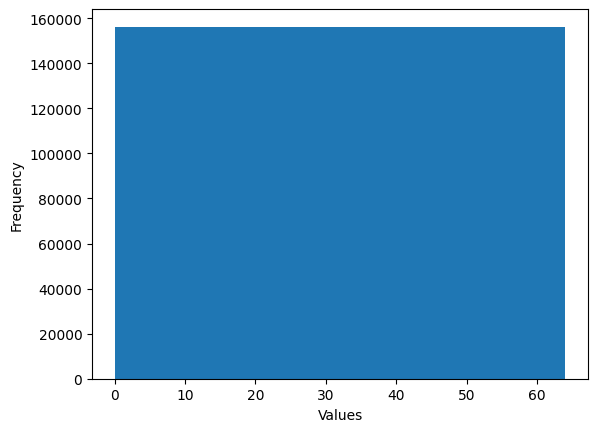

In [22]:
plt.hist(sequence, bins=modulus, range=(0, modulus))

plt.xlabel("Values")
plt.ylabel("Frequency")

plt.show()

In [ ]:
def compute_entropy(X):
    """ 
    You can pass in the random variable X in whatever form you choose.
    One way to represent a random variable is as a dictionary, 
    where each (key, value) pair represents an outcome x 
    and its probability P(X = x)

    Hint: NumPy might be helpful here!
    """

    # Shannon Entropy

    return -(X * np.log(X)).sum()

In [37]:
""" 
1. fix a short seed value for each LCG 
(no more than 2^10 possible values for the seed)

2. Over a long LCG sequence (at least 10^6 samples),
as the generator produces values, treat the sequence of outputs 
up to each step as a growing empirical distribution.

3. At regular intervals (e.g., every 1000 iterations), 
compute the Shannon Entropy or Min-Entropy 
of the current sample distribution.

Hint: We've already imported matplotlib for you, 
though any plotting package will do the trick.
"""

seed = 345
iterations = int(10e6)
interval = 1000

sequence = Linear_Congruential_Generator(seed, multiplier, increment, modulus, iterations)

entropy_vals = []

for i in range(0, iterations, interval):
    n = i + interval
    sample = sequence[:n]
    X = np.unique_counts(sample).counts / n
    entropy_vals.append(compute_entropy(X))

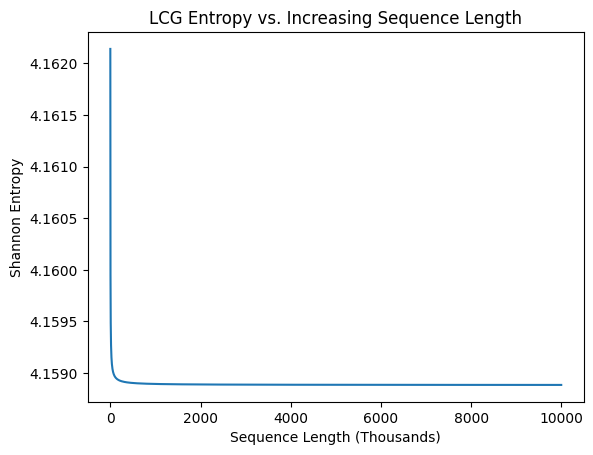

In [61]:
plt.plot(entropy_vals)

plt.xlabel("Sequence Length (Thousands)")
plt.ylabel("Shannon Entropy")

plt.title("LCG Entropy vs. Increasing Sequence Length")

plt.show()

### Part B: Implement and Benchmark AES-Based PRNGs

In [124]:
# Here is a reference implementation of the AES algorithm: https://github.com/burakozpoyraz/Advanced-Encryption-Standard/tree/master
# ADVANCED ENCRYPTION STANDARD (AES) - 128 / Rijndael Cipher Algorithm

from copy import deepcopy

# ENCRYPTION ALGORITHM                 
# SubBytes //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#           00   01   02   03   04   05   06   07   08   09   0a   0b   0c   0d   0e   0f
s_box = [[0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76], #00
         [0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0], #10
         [0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15], #20
         [0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75], #30
         [0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84], #40
         [0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf], #50
         [0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8], #60
         [0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2], #70
         [0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73], #80
         [0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb], #90
         [0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79], #a0
         [0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08], #b0
         [0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a], #c0
         [0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e], #d0
         [0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf], #e0
         [0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16]] #f0

def SubBytesTransformation(state_matrix):
   new_state_matrix = deepcopy(state_matrix)

   row_dim = len(new_state_matrix)
   col_dim = len(new_state_matrix[0])

   for row in range(0,row_dim):
      for col in range(0,col_dim):
         num_str = new_state_matrix[row][col]
         s_row = num_str[2]
         s_col = num_str[3]

         if s_row == 'a':
            s_row = 10
         elif s_row == 'b':
            s_row = 11
         elif s_row == 'c':
            s_row = 12
         elif s_row == 'd':
            s_row = 13
         elif s_row == 'e':
            s_row = 14
         elif s_row == 'f':
            s_row = 15
         else:
            s_row = int(s_row)

         if s_col == 'a':
            s_col = 10
         elif s_col == 'b':
            s_col = 11
         elif s_col == 'c':
            s_col = 12
         elif s_col == 'd':
            s_col = 13
         elif s_col == 'e':
            s_col = 14
         elif s_col == 'f':
            s_col = 15
         else:
            s_col = int(s_col)

         new_state_matrix[row][col] = "0x{:02x}".format(s_box[s_row][s_col])

   return new_state_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# ShiftRows /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
def ShiftArray(array, n, direction):
   len_array = len(array)
   shifted_array = []
   for index in range(0, len_array):
      shifted_array.append("0")

   if direction == 'left':
      for i in range(0, len_array):
         new_index = (i - n + n * len(array)) % len(array)
         shifted_array[new_index] = array[i]
   elif direction == 'right':
      for i in range(0, len_array):
         new_index = (i + n) % len(array)
         shifted_array[new_index] = array[i]
   return shifted_array

def ShiftRows(matrix):
   new_matrix = deepcopy(matrix)
   for row in range(1, 4):
      new_matrix[row] = ShiftArray(new_matrix[row], row, 'left')
   return new_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# MixColumns ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
mix_column_matrix = [[0x02,0x03,0x01,0x01],
                     [0x01,0x02,0x03,0x01],
                     [0x01,0x01,0x02,0x03],
                     [0x03,0x01,0x01,0x02]]

def GaloisMultiplication(number, multiplier):
   number_bin = format(number, '08b')
   if multiplier == 0x01:
      return number
   elif multiplier == 0x02:
      mask = 2 ** 8 - 1
      num_shifted = (number << 1) & mask
      if number_bin[0] == '0':
         return num_shifted
      else:
         return (num_shifted ^ 0b00011011)
   elif multiplier == 0x03:
      return (GaloisMultiplication(number, 0x02) ^ number)
   elif multiplier == 0x09:
      a = number
      for i in range(0, 3):
         a = GaloisMultiplication(a, 0x02)
      return (a ^ number)
   elif multiplier == 0x0b:
      a = number
      for i in range(0, 2):
         a = GaloisMultiplication(a, 0x02)
      a = a ^ number
      a = GaloisMultiplication(a, 0x02)
      return (a ^ number)
   elif multiplier == 0x0d:
      a = number
      a = GaloisMultiplication(a, 0x02)
      a = a ^ number
      for i in range(0, 2):
         a = GaloisMultiplication(a, 0x02)
      return (a ^ number)
   elif multiplier == 0x0e:
      a = number
      for i in range(0, 2):
         a = GaloisMultiplication(a, 0x02)
         a = a ^ number
      return (GaloisMultiplication(a, 0x02))

def MixColumns(matrix):
   new_matrix = deepcopy(matrix)
   for c in range(0, 4):
      new_column = [0,0,0,0]
      column = [new_matrix[0][c],new_matrix[1][c],new_matrix[2][c],new_matrix[3][c]]
      for row in range(0, 4):
         for col in range(0, 4):
            new_column[row] ^= GaloisMultiplication(int(column[col], 16), mix_column_matrix[row][col])
      for r in range(0, 4):
         new_matrix[r][c] = "0x{:02x}".format(new_column[r])
   return new_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# AddRoundKey ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////
def AddRoundKey(matrix, round_key):
   new_matrix = deepcopy(matrix)
   for row in range(0, 4):
      for col in range(0, 4):
         new_matrix[row][col] = "0x{:02x}".format(int(new_matrix[row][col], 16) ^ int(round_key[row][col], 16))
   return new_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Key Schedule //////////////////////////////////////////////////////////////////////////////////////////////////////////////////
rcon =[[0x01,0x02,0x04,0x08,0x10,0x20,0x40,0x80,0x1b,0x36],
       [0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00],
       [0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00],
       [0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00]]

def CreateWord(round_key, round_index, word_index):
   rcon_column = [0,0,0,0]
   word = [0,0,0,0]

   if word_index == 1:
      round_key_first_word = [0,0,0,0]
      round_key_last_word = [0,0,0,0]

      for row in range(0, 4):
         round_key_first_word[row] = round_key[row][0]
         round_key_last_word[row] = round_key[row][3]
         rcon_column[row] = rcon[row][round_index - 1]

      rot_word =  [ShiftArray(round_key_last_word, 1, 'left')]
      s_rot_word = SubBytesTransformation(rot_word)

      for row in range(0, 4):
         word[row] = "0x{:02x}".format(int(round_key_first_word[row], 16) ^ int(s_rot_word[0][row], 16) ^ rcon_column[row])
   else:
      previous_word = CreateWord(round_key, round_index, (word_index - 1))
      round_key_word = [0,0,0,0]

      for row in range(0, 4):
         previous_word[row] = int(previous_word[row], 16)
         round_key_word[row] = int(round_key[row][word_index - 1], 16)
         word[row] = "0x{:02x}".format(previous_word[row] ^ round_key_word[row])
   return word

def GenerateRoundKey(round_key, round_index):
   new_round_key = [[0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0]]
   
   for col in range(0, 4):
      word = CreateWord(round_key, round_index, (col + 1))
      for row in range(0, 4):
         new_round_key[row][col] = word[row]
   return new_round_key
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Encryption ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
def AES_Encrypt(state_matrix, cipher_key):

   new_state_matrix = deepcopy(state_matrix)
   round_key = deepcopy(cipher_key)

   new_state_matrix = AddRoundKey(new_state_matrix, round_key)

   for i in range(1, 10):
      new_state_matrix = SubBytesTransformation(new_state_matrix)
      new_state_matrix = ShiftRows(new_state_matrix)
      new_state_matrix = MixColumns(new_state_matrix)
      round_key = GenerateRoundKey(round_key, i)
      new_state_matrix = AddRoundKey(new_state_matrix, round_key)

   new_state_matrix = SubBytesTransformation(new_state_matrix)
   new_state_matrix = ShiftRows(new_state_matrix)
   round_key = GenerateRoundKey(round_key, 10)
   new_state_matrix = AddRoundKey(new_state_matrix, round_key)

   return new_state_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Message Encryption ////////////////////////////////////////////////////////////////////////////////////////////////////////////
def EncryptMessage(message, cipher_key):
   encrypted_message = ""

   message_ascii = []
   for c in message:
      message_ascii.append(ord(c))

   buffer_matrix = [[0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0]]
   iter_num = int(len(message_ascii) / 16)
   for iter_index in range(0, iter_num):
      for element_index in range(0, 16):
         buffer_matrix[int(element_index / 4)][element_index % 4] = message_ascii.pop(0)
         buffer_matrix_string = deepcopy(buffer_matrix)
         for row in range(0, 4):
            for col in range(0, 4):
               buffer_matrix_string[row][col] = "0x{:02x}".format(buffer_matrix_string[row][col])

      encrypted_buffer_matrix = AES_Encrypt(buffer_matrix_string, cipher_key)

      for row in range(0, 4):
         for col in range(0, 4):
            dec_value = int(encrypted_buffer_matrix[row][col], 16)
            encrypted_message += chr((dec_value % 94) + 33)
            encrypted_message += str(int(dec_value / 94))

   if len(message_ascii) > 0:
      for element_index in range(0, 16):
         if len(message_ascii) > 0:
            buffer_matrix[int(element_index / 4)][element_index % 4] = message_ascii.pop(0)
         else:
            buffer_matrix[int(element_index / 4)][element_index % 4] = 0
            buffer_matrix_string = deepcopy(buffer_matrix)
            for row in range(0, 4):
               for col in range(0, 4):
                  buffer_matrix_string[row][col] = "0x{:02x}".format(buffer_matrix_string[row][col])
                  
      encrypted_buffer_matrix = AES_Encrypt(buffer_matrix_string, cipher_key)

      for row in range(0, 4):
         for col in range(0, 4):
            dec_value = int(encrypted_buffer_matrix[row][col], 16)
            encrypted_message += chr((dec_value % 94) + 33)
            encrypted_message += str(int(dec_value / 94))
   return encrypted_message
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# DECRYPTION ALGORITHM
# Inverse SubBytes //////////////////////////////////////////////////////////////////////////////////////////////////////////////
#              00   01   02   03   04   05   06   07   08   09   0a   0b   0c   0d   0e   0f
inv_s_box = [[0x52,0x09,0x6a,0xd5,0x30,0x36,0xa5,0x38,0xbf,0x40,0xa3,0x9e,0x81,0xf3,0xd7,0xfb], #00
             [0x7c,0xe3,0x39,0x82,0x9b,0x2f,0xff,0x87,0x34,0x8e,0x43,0x44,0xc4,0xde,0xe9,0xcb], #10
             [0x54,0x7b,0x94,0x32,0xa6,0xc2,0x23,0x3d,0xee,0x4c,0x95,0x0b,0x42,0xfa,0xc3,0x4e], #20
             [0x08,0x2e,0xa1,0x66,0x28,0xd9,0x24,0xb2,0x76,0x5b,0xa2,0x49,0x6d,0x8b,0xd1,0x25], #30
             [0x72,0xf8,0xf6,0x64,0x86,0x68,0x98,0x16,0xd4,0xa4,0x5c,0xcc,0x5d,0x65,0xb6,0x92], #40
             [0x6c,0x70,0x48,0x50,0xfd,0xed,0xb9,0xda,0x5e,0x15,0x46,0x57,0xa7,0x8d,0x9d,0x84], #50
             [0x90,0xd8,0xab,0x00,0x8c,0xbc,0xd3,0x0a,0xf7,0xe4,0x58,0x05,0xb8,0xb3,0x45,0x06], #60
             [0xd0,0x2c,0x1e,0x8f,0xca,0x3f,0x0f,0x02,0xc1,0xaf,0xbd,0x03,0x01,0x13,0x8a,0x6b], #70
             [0x3a,0x91,0x11,0x41,0x4f,0x67,0xdc,0xea,0x97,0xf2,0xcf,0xce,0xf0,0xb4,0xe6,0x73], #80
             [0x96,0xac,0x74,0x22,0xe7,0xad,0x35,0x85,0xe2,0xf9,0x37,0xe8,0x1c,0x75,0xdf,0x6e], #90
             [0x47,0xf1,0x1a,0x71,0x1d,0x29,0xc5,0x89,0x6f,0xb7,0x62,0x0e,0xaa,0x18,0xbe,0x1b], #a0
             [0xfc,0x56,0x3e,0x4b,0xc6,0xd2,0x79,0x20,0x9a,0xdb,0xc0,0xfe,0x78,0xcd,0x5a,0xf4], #b0
             [0x1f,0xdd,0xa8,0x33,0x88,0x07,0xc7,0x31,0xb1,0x12,0x10,0x59,0x27,0x80,0xec,0x5f], #c0
             [0x60,0x51,0x7f,0xa9,0x19,0xb5,0x4a,0x0d,0x2d,0xe5,0x7a,0x9f,0x93,0xc9,0x9c,0xef], #d0
             [0xa0,0xe0,0x3b,0x4d,0xae,0x2a,0xf5,0xb0,0xc8,0xeb,0xbb,0x3c,0x83,0x53,0x99,0x61], #e0
             [0x17,0x2b,0x04,0x7e,0xba,0x77,0xd6,0x26,0xe1,0x69,0x14,0x63,0x55,0x21,0x0c,0x7d]] #f0

def InvSubBytesTransformation(state_matrix):
   new_state_matrix = deepcopy(state_matrix)

   row_dim = len(new_state_matrix)
   col_dim = len(new_state_matrix[0])

   for row in range(0,row_dim):
      for col in range(0,col_dim):
         num_str = new_state_matrix[row][col]
         s_row = num_str[2]
         s_col = num_str[3]

         if s_row == 'a':
            s_row = 10
         elif s_row == 'b':
            s_row = 11
         elif s_row == 'c':
            s_row = 12
         elif s_row == 'd':
            s_row = 13
         elif s_row == 'e':
            s_row = 14
         elif s_row == 'f':
            s_row = 15
         else:
            s_row = int(s_row)

         if s_col == 'a':
            s_col = 10
         elif s_col == 'b':
            s_col = 11
         elif s_col == 'c':
            s_col = 12
         elif s_col == 'd':
            s_col = 13
         elif s_col == 'e':
            s_col = 14
         elif s_col == 'f':
            s_col = 15
         else:
            s_col = int(s_col)

         new_state_matrix[row][col] = "0x{:02x}".format(inv_s_box[s_row][s_col])

   return new_state_matrix            
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Inverse ShiftRows /////////////////////////////////////////////////////////////////////////////////////////////////////////////
def InvShiftRows(matrix):
   new_matrix = deepcopy(matrix)
   for row in range(1, 4):
      new_matrix[row] = ShiftArray(new_matrix[row], row, 'right')
   return new_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Inverse MixColumns ////////////////////////////////////////////////////////////////////////////////////////////////////////////
inv_mix_column_matrix = [[0x0e,0x0b,0x0d,0x09],
                         [0x09,0x0e,0x0b,0x0d],
                         [0x0d,0x09,0x0e,0x0b],
                         [0x0b,0x0d,0x09,0x0e]]

def InvMixColumns(matrix):
   new_matrix = deepcopy(matrix)
   for c in range(0, 4):
      new_column = [0,0,0,0]
      column = [new_matrix[0][c],new_matrix[1][c],new_matrix[2][c],new_matrix[3][c]]
      for row in range(0, 4):
         for col in range(0, 4):
            new_column[row] ^= GaloisMultiplication(int(column[col], 16), inv_mix_column_matrix[row][col])
      for r in range(0, 4):
         new_matrix[r][c] = "0x{:02x}".format(new_column[r])
   return new_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Decryption ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
def AES_Decrypt(state_matrix, cipher_key):
   new_state_matrix = deepcopy(state_matrix)
   round_key = deepcopy(cipher_key)

   round_keys_box = {}

   for round_index in range(0, 11):
      if round_index != 0:
         round_key = GenerateRoundKey(round_key, round_index)
      for row in range(0, 4):
         for col in range(0, 4):
            round_keys_box[round_index, row, col] = round_key[row][col]
   
   new_state_matrix = AddRoundKey(new_state_matrix, round_key)
   new_state_matrix = InvShiftRows(new_state_matrix)
   new_state_matrix = InvSubBytesTransformation(new_state_matrix)

   for round_index in range(1, 10):
      for row in range(0, 4):
         for col in range(0, 4):
            round_key[row][col] = round_keys_box[(10 - round_index), row, col]

      new_state_matrix = AddRoundKey(new_state_matrix, round_key)
      new_state_matrix = InvMixColumns(new_state_matrix)
      new_state_matrix = InvShiftRows(new_state_matrix)
      new_state_matrix = InvSubBytesTransformation(new_state_matrix)

   for row in range(0, 4):
      for col in range(0, 4):
         round_key[row][col] = round_keys_box[0, row, col]
   new_state_matrix = AddRoundKey(new_state_matrix, round_key)
   return new_state_matrix
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Message Decryption ////////////////////////////////////////////////////////////////////////////////////////////////////////////
def DecryptMessage(encrypted_message, cipher_key):
   decrypted_message = ""

   buffer_matrix = [[0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0],
                    [0,0,0,0]]
   encrypted_message_dec = []
   encrypted_message_length = len(encrypted_message)
   for char_index in range(0, encrypted_message_length, 2):
      encrypted_char = encrypted_message[char_index]
      encryption_info = encrypted_message[char_index + 1]

      dec_value = (ord(encrypted_char) - 33) + (int(encryption_info) * 94)
      encrypted_message_dec.append(dec_value)

   iter_num = int(len(encrypted_message_dec) / 16)
   for iter_index in range(0, iter_num):
      for element_index in range(0, 16):
         buffer_matrix[int(element_index / 4)][element_index % 4] = encrypted_message_dec.pop(0)
         buffer_matrix_string = deepcopy(buffer_matrix)
         for row in range(0, 4):
            for col in range(0, 4):
               buffer_matrix_string[row][col] = "0x{:02x}".format(buffer_matrix_string[row][col])

      decrypted_buffer_matrix = AES_Decrypt(buffer_matrix_string, cipher_key)

      for row in range(0, 4):
         for col in range(0, 4):
            decrypted_dec_value = int(decrypted_buffer_matrix[row][col], 16)
            if decrypted_dec_value != 0:
               decrypted_message += chr(decrypted_dec_value)
   return decrypted_message
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# MAIN ALGORITHM /////////////////////////////////////////////////////////////////////////////////////////////////////////////////
cipher_key = [["0x2b","0x28","0xab","0x09"],
              ["0x7e","0xae","0xf7","0xcf"],
              ["0x15","0xd2","0x15","0x4f"],
              ["0x16","0xa6","0x88","0x3c"]]

message = "Burak. | Stay With Tech :)"
print("Message: " + message)
print("")
encrypted_message = EncryptMessage(message, cipher_key)

print("Encrypted Message: " + encrypted_message)
print("")

decrypted_message = DecryptMessage(encrypted_message, cipher_key)
print("Decrypted Message: " + decrypted_message)
print("")
#////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Message: Burak. | Stay With Tech :)

Encrypted Message: 60"1E180B1&0&1:241&2:2"2H0l0R2[0:140=110K251G1(1]0[192P1j0Y141>0

Decrypted Message: Burak. | Stay With Tech :)



In [75]:
# TODO: helper function to pad/truncate the seed to 16 bytes (128 bits)
def pad_seed(seed_bytes, target_len=16):
    return seed_bytes * (target_len // len(seed_bytes))

# TODO: implement a simple AES-based PRNG using ECB mode
def AES_PRNG(seed, num_bytes):
    sequence = []
    padded_seed = pad_seed(seed, 16)
    key = [[0 for _ in range(4)] for _ in range(4)]
    for i in range(4):
        for j in range(4):
            key[i][j] = format(padded_seed[i * 4 + j], "#04x")
    
    block = b'\x00' * 16
    iterations = math.ceil(num_bytes / 16)

    for x in range(iterations):
        h = f"{hex(x)[2:]:>32}".replace(" ", "0")
        block = [[f"0x{h[j]}{h[j+1]}" for j in range(i, i + 8, 2)] for i in range(0, 32, 8)]
        result = AES_Encrypt(block, key)
        sequence.append(result)

        if x % 1000 == 0:
            print(f"Done with {x}/{iterations}")

    return sequence

In [60]:
x = 10
h = f"{hex(x)[2:]:>32}".replace(" ", "0")
arr = [[f"0x{h[j]}{h[j+1]}" for j in range(i, i + 8, 2)] for i in range(0, 32, 8)]
print(arr)

[['0x00', '0x00', '0x00', '0x00'], ['0x00', '0x00', '0x00', '0x00'], ['0x00', '0x00', '0x00', '0x00'], ['0x00', '0x00', '0x00', '0x0a']]


In [76]:
# TODO: choose at least 3 different seed lengths (e.g., 8, 16, 64 bits)
seed_lengths = [1, 2, 8]  # in bytes

# TODO: generate sequences of increasing length (10^5 to 10^7) for each seed length
sequence_lengths = [10**5, 10**6, 10**7]

In [91]:
# Example: Generate and store sequences
all_sequences = {}

for seed_len in seed_lengths:
    seed = np.random.bytes(seed_len)
    all_sequences[seed_len] = {}

    for seq_len in sequence_lengths:
        prng_output = AES_PRNG(seed, seq_len)
        all_sequences[seed_len][seq_len] = prng_output

Done with 0/6250
Done with 1000/6250
Done with 2000/6250
Done with 3000/6250
Done with 4000/6250
Done with 5000/6250
Done with 6000/6250
Done with 0/62500
Done with 1000/62500
Done with 2000/62500
Done with 3000/62500
Done with 4000/62500
Done with 5000/62500
Done with 6000/62500
Done with 7000/62500
Done with 8000/62500
Done with 9000/62500
Done with 10000/62500
Done with 11000/62500
Done with 12000/62500
Done with 13000/62500
Done with 14000/62500
Done with 15000/62500
Done with 16000/62500
Done with 17000/62500
Done with 18000/62500
Done with 19000/62500
Done with 20000/62500
Done with 21000/62500
Done with 22000/62500
Done with 23000/62500
Done with 24000/62500
Done with 25000/62500
Done with 26000/62500
Done with 27000/62500
Done with 28000/62500
Done with 29000/62500
Done with 30000/62500
Done with 31000/62500
Done with 32000/62500
Done with 33000/62500
Done with 34000/62500
Done with 35000/62500
Done with 36000/62500
Done with 37000/62500
Done with 38000/62500
Done with 39000/62

In [152]:
# TODO: plot entropy across chunks of the output to study randomness
def plot_entropy(sequence, window_size=1000):
    entropy_vals = []

    for i in range(0, len(sequence), window_size):
        n = i + window_size
        sample = sequence[:n]
        X = np.unique_counts(sample).counts / n
        entropy_vals.append(compute_entropy(X))

    plt.plot(entropy_vals)

    plt.xlabel("Sequence Length (Thousands)")
    plt.ylabel("Shannon Entropy")

    plt.title("AES Entropy vs. Increasing Sequence Length")

    plt.show()

In [157]:
def calculate_autocorrelation(X, k):
    mean = X.mean()
    numerator = np.cov(X[:len(X) - k] - mean, X[k:] - mean)[0, 1]
    denominator = np.var(X)
    return numerator / denominator

def plot_autocorrelation(sequence, max_lag=100):
    autocor_vals = []

    for i in range(max_lag):
        autocor_vals.append(calculate_autocorrelation(sequence, i))

    plt.plot(autocor_vals)

    plt.xlabel("lag")
    plt.ylabel("Autocorrelation")

    plt.title("AES Autocorrelation vs. lag")

    plt.show()

In [202]:
def run_statistical_tests(sequence, item_bits=8):
    # Chi Squared

    uniform_freq = len(sequence) / (2**item_bits)
    counts = np.unique_counts(sequence).counts
    chi_sq = (((counts - uniform_freq) ** 2) / uniform_freq).sum()

    print("χ^2 = " + str(chi_sq))

### Seed Length 1

### Sequence Length 10^5

In [118]:
seq_1 = all_sequences[1][10**5]
seq_1_flat = np.array([int(item, 16) for sublist in seq_1 for row in sublist for item in row])

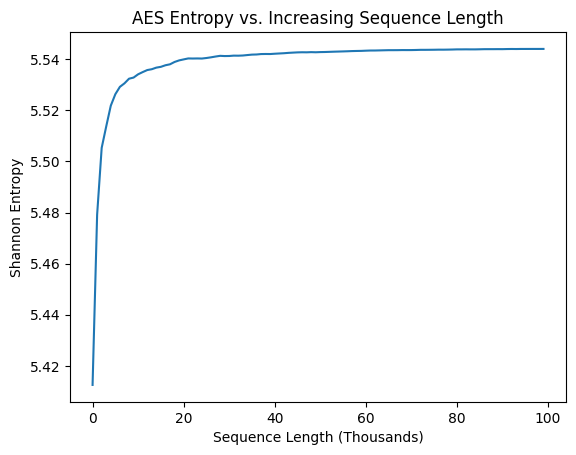

In [153]:
plot_entropy(seq_1_flat)

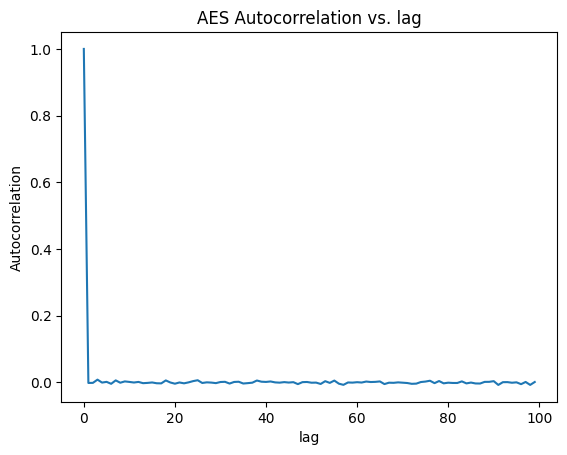

In [159]:
plot_autocorrelation(seq_1_flat)

In [203]:
run_statistical_tests(seq_1_flat)

χ^2 = 225.87392


### Sequence Length 10^6

In [131]:
seq_2 = all_sequences[1][10**6]
seq_2_flat = np.array([int(item, 16) for sublist in seq_2 for row in sublist for item in row])

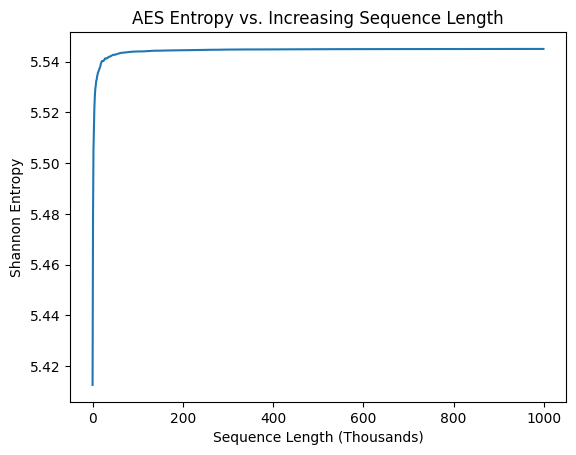

In [154]:
plot_entropy(seq_2_flat)

In [ ]:
plot_entropy(seq_2_flat)

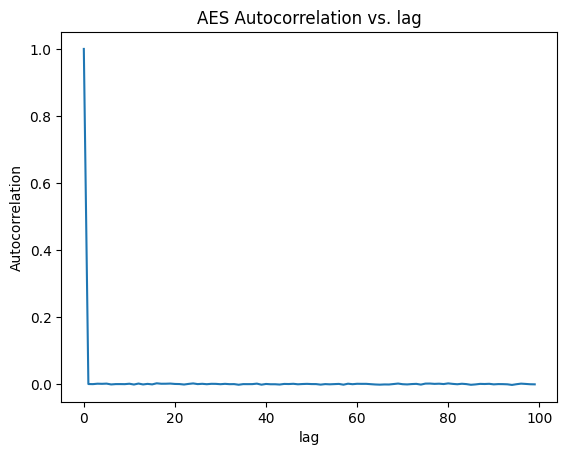

In [161]:
plot_autocorrelation(seq_2_flat)

In [204]:
run_statistical_tests(seq_2_flat)

χ^2 = 228.588032


### Sequence Length 10^7

In [155]:
seq_3 = all_sequences[1][10**7]
seq_3_flat = np.array([int(item, 16) for sublist in seq_3 for row in sublist for item in row])

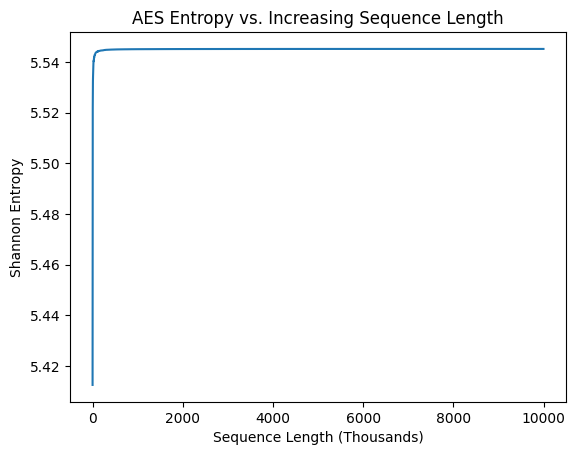

In [156]:
plot_entropy(seq_3_flat)

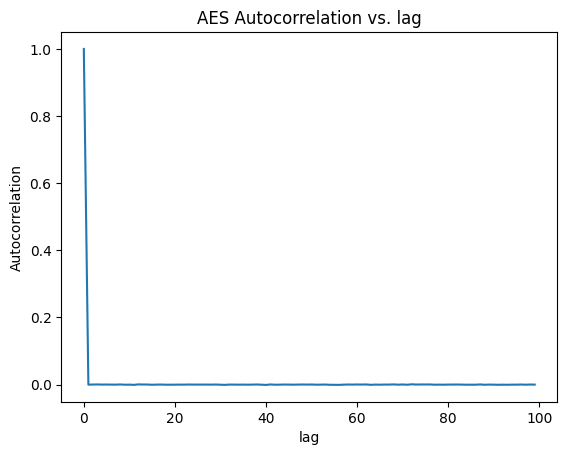

In [163]:
plot_autocorrelation(seq_3_flat)

In [205]:
run_statistical_tests(seq_3_flat)

χ^2 = 269.8491904


### Seed Length 2

### Sequence Length 10^5

In [165]:
seq_4 = all_sequences[2][10**5]
seq_4_flat = np.array([int(item, 16) for sublist in seq_4 for row in sublist for item in row])

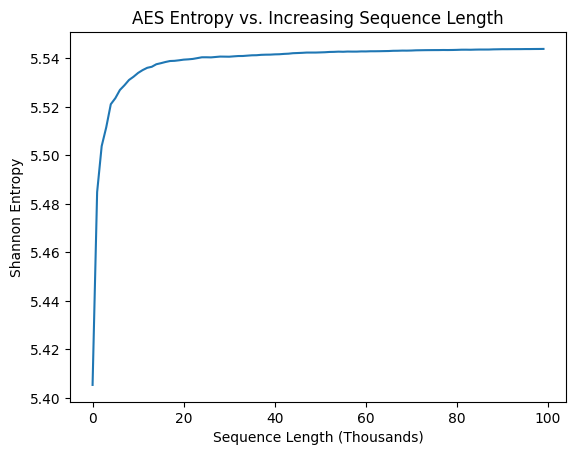

In [166]:
plot_entropy(seq_4_flat)

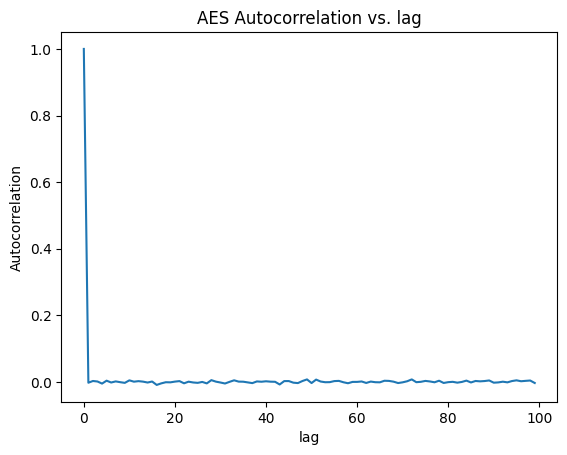

In [167]:
plot_autocorrelation(seq_4_flat)

In [206]:
run_statistical_tests(seq_4_flat)

χ^2 = 251.20768


### Sequence Length 10^6

In [169]:
seq_5 = all_sequences[2][10**6]
seq_5_flat = np.array([int(item, 16) for sublist in seq_5 for row in sublist for item in row])

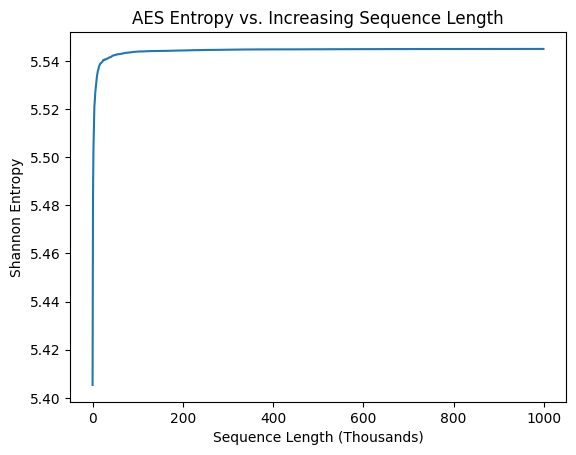

In [170]:
plot_entropy(seq_5_flat)

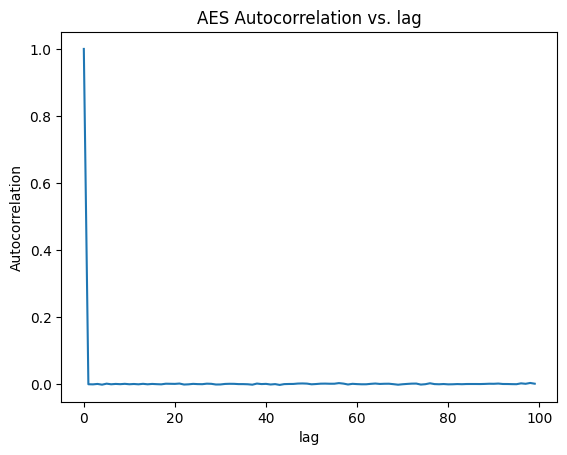

In [172]:
plot_autocorrelation(seq_5_flat)

In [207]:
run_statistical_tests(seq_5_flat)

χ^2 = 272.37427199999996


### Sequence Length 10^7

In [175]:
seq_6 = all_sequences[2][10**7]
seq_6_flat = np.array([int(item, 16) for sublist in seq_6 for row in sublist for item in row])

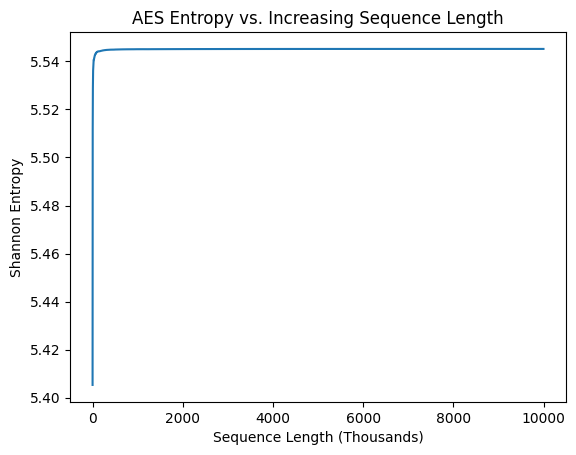

In [176]:
plot_entropy(seq_6_flat)

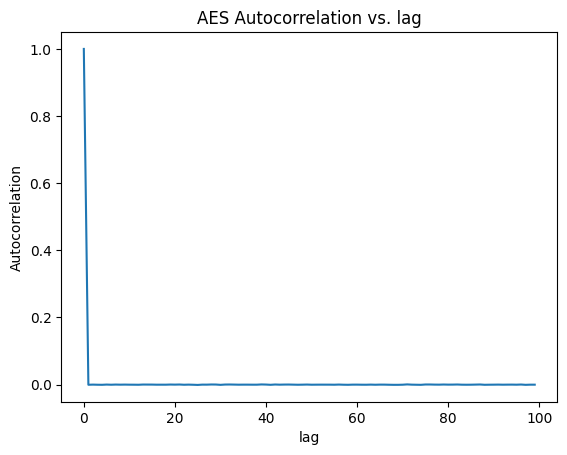

In [177]:
plot_autocorrelation(seq_6_flat)

In [208]:
run_statistical_tests(seq_6_flat)

χ^2 = 310.04472319999996


### Seed Length 8

### Sequence Length 10^5

In [180]:
seq_7 = all_sequences[8][10**5]
seq_7_flat = np.array([int(item, 16) for sublist in seq_7 for row in sublist for item in row])

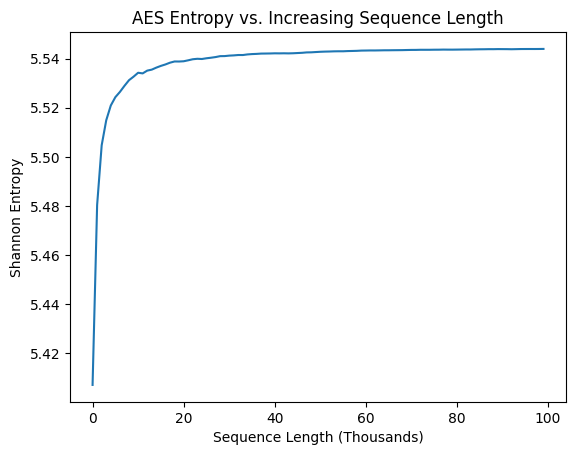

In [181]:
plot_entropy(seq_7_flat)

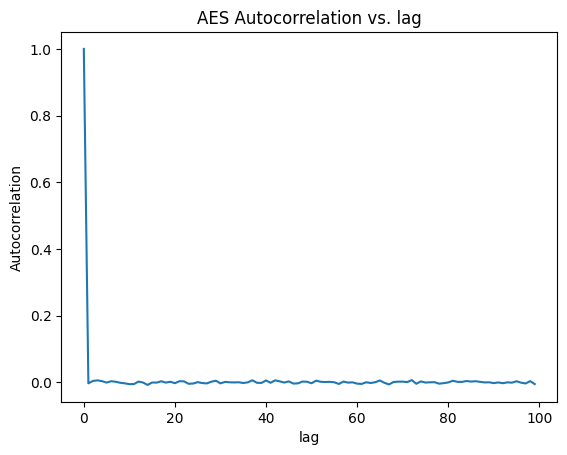

In [182]:
plot_autocorrelation(seq_7_flat)

In [209]:
run_statistical_tests(seq_7_flat)

χ^2 = 246.03648


### Sequence Length 10^6

In [184]:
seq_8 = all_sequences[8][10**6]
seq_8_flat = np.array([int(item, 16) for sublist in seq_8 for row in sublist for item in row])

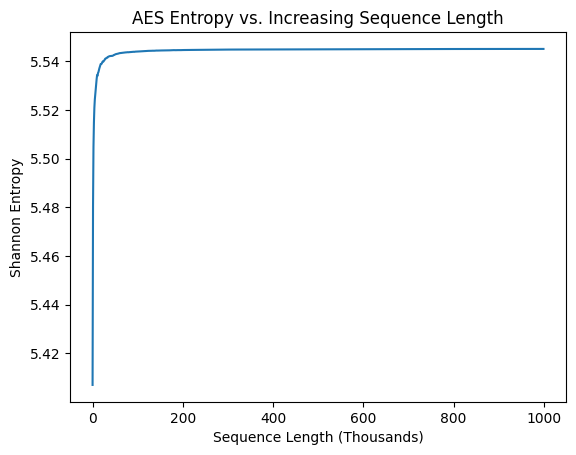

In [185]:
plot_entropy(seq_8_flat)

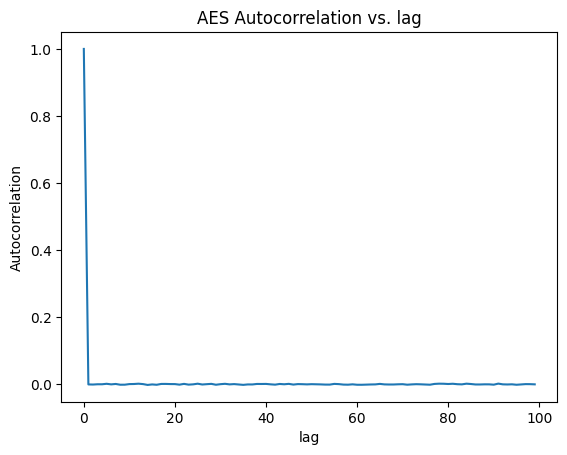

In [186]:
plot_autocorrelation(seq_8_flat)

In [210]:
run_statistical_tests(seq_8_flat)

χ^2 = 294.97856


### Sequence Length 10^7

In [188]:
seq_9 = all_sequences[8][10**7]
seq_9_flat = np.array([int(item, 16) for sublist in seq_9 for row in sublist for item in row])

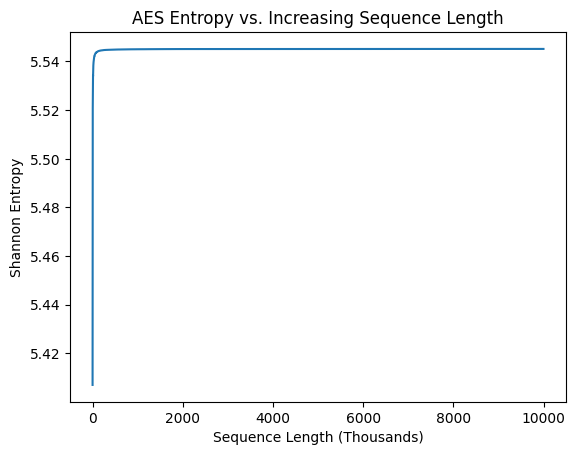

In [191]:
plot_entropy(seq_9_flat)

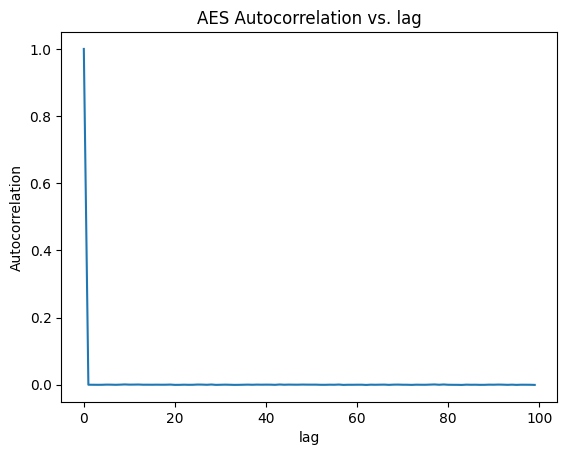

In [189]:
plot_autocorrelation(seq_9_flat)

In [211]:
run_statistical_tests(seq_9_flat)

χ^2 = 269.007872


### (BONUS) Part C: Breaking the Illusion of Randomness

### Bonus Task:
Train a light-weight model (small-neural net or decision tree) to predict the next number in your random number sequences generated from LCG and AES. Now try implementing at least one other more robust PRNGs from the list below:
- XOR-Shift Generator
- Permuted Congruential Generator (PCG) 
- SplitMix64 

In [78]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 5.7 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


## LCG

In [85]:
X, y = [], []

for i in range(0, (len(sequence) // 100) * 100, 100):
    X.append(sequence[i:i + 99])
    y.append(sequence[i + 99])

In [86]:
from sklearn.utils import shuffle

X_y_pairs = list(zip(X, y))
X_y_pairs = shuffle(X_y_pairs)
X, y = zip(*X_y_pairs)

In [88]:
train_X, test_X = X[:int(len(X) * 0.9)], X[int(len(X) * 0.9):]
train_y, test_y = y[:int(len(y) * 0.9)], y[int(len(y) * 0.9):]

In [89]:
import sklearn.tree

model = sklearn.tree.DecisionTreeClassifier(criterion="entropy")
model.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy')

In [90]:
model.score(test_X, test_y)

1.0

100% accuracy prediction for LCG

## AES

In [253]:
X, y = [], []

for i in range(0, (len(seq_9_flat) // 100) * 100, 100):
    X.append(seq_9_flat[i:i + 99])
    y.append(seq_9_flat[i + 99])

In [254]:
from sklearn.utils import shuffle

X_y_pairs = list(zip(X, y))
X_y_pairs = shuffle(X_y_pairs)
X, y = zip(*X_y_pairs)

In [255]:
train_X, test_X = X[:int(len(X) * 0.9)], X[int(len(X) * 0.9):]
train_y, test_y = y[:int(len(y) * 0.9)], y[int(len(y) * 0.9):]

In [256]:
import sklearn.tree

model = sklearn.tree.DecisionTreeClassifier(criterion="entropy")
model.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy')

In [257]:
model.score(test_X, test_y)

0.0041

0.41% accuracy prediction for AES